In [5]:
import pandas as pd  # For manipulating data structures
import numpy as np  # For mathematical functions
import scipy.stats as stats  # Algorithms and convenience functions built on NumPy
import statsmodels.api as sm  # For statistical methods
import statsmodels.formula.api as smf  # For writing formulas
import patsy
import matplotlib.pyplot as plt  # Essentially the Python equivalent to ggplot2
import seaborn as sns  # A library for statistical graphics built on Matplotlib

custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
}
sns.set_theme(
    context="notebook",
    style="ticks",
    palette="colorblind",
    rc=custom_params,
)

scavengers = pd.read_csv("../data/cleaned scavenger data.csv", index_col="Species name")

scavengers.drop(
    ["BirdLife Extent of occurrence"], axis=1, inplace=True
)

Text(0.02, 0.5, 'Number of species')

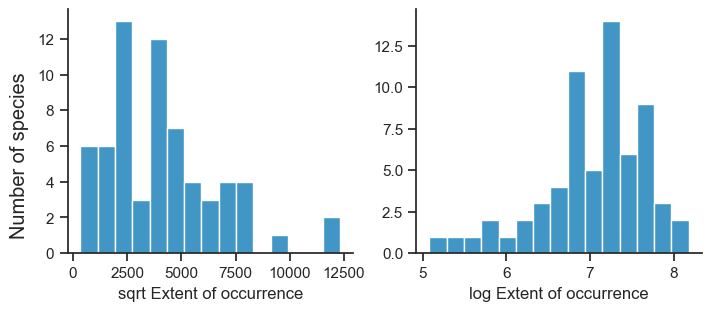

In [2]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(7,3), layout="constrained")

sns.histplot(
    ax=ax1,
    data=scavengers,
    x=np.sqrt(scavengers["Extent of occurrence"]),
    bins=15,
)
sns.histplot(
    ax=ax2,
    data=scavengers,
    x="log Extent of occurrence",
    bins=15
)
ax1.set_xlabel("sqrt Extent of occurrence")
ax1.set_ylabel("")
ax2.set_ylabel("")
fig.supylabel("Number of species")

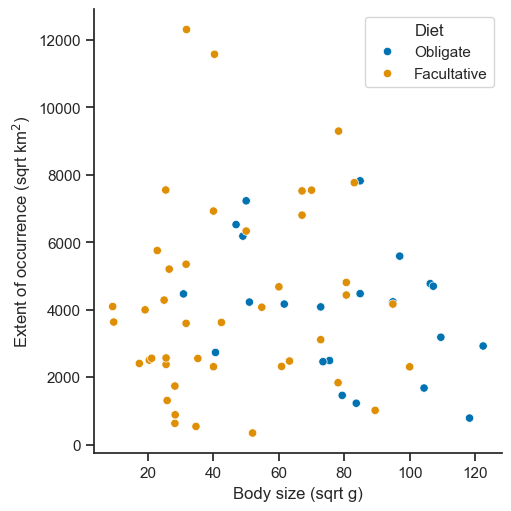

In [3]:
fig, ax = plt.subplots(1,1, figsize=(5,5), layout="constrained")

sns.scatterplot(
    data=scavengers,
    x=np.sqrt(scavengers["Body size"]),
    y=np.sqrt(scavengers["Extent of occurrence"]),
    hue="Diet",
)
ax.set_ylabel("Extent of occurrence (sqrt km$^2$)")
ax.set_xlabel("Body size (sqrt g)")
plt.show()

Check whether the log-transformed data have the skewness and kurtosis of a normal distribution.

The Raw Data Jarque-Bera test statistic below concurs with the above histograms that our data distribution is not normally distributed when examining all scavengers as a single group, but are normally distributed when log-transformed.

Note that I should only take this test with a grain of salt, because the sample size is much smaller than what is advised (>2000).

In [4]:
body_jb_test = stats.jarque_bera(x=(scavengers["log Body size"]))

eoo_jb_test = stats.jarque_bera(x=scavengers["log Extent of occurrence"])

print(f"log body size Jarque-Bera Test:\nStatistic: {body_jb_test.statistic:.2f}, p-value: {body_jb_test.pvalue:.5f}")

print(f"log EOO Jarque-Bera Test:\nStatistic: {eoo_jb_test.statistic:.2f}, p-value: {eoo_jb_test.pvalue:.5f}")

log body size Jarque-Bera Test:
Statistic: 4.07, p-value: 0.13076
log EOO Jarque-Bera Test:
Statistic: 9.46, p-value: 0.00884


Check whether the log-transformed data have the skewness and kurtosis of a normal distribution. I selected the Shapiro-Wilk test because it is better suited for small sample sizes than something like the Jarque-Bera test, which is better suited for >2000 samples for the `jarque-bera` test from Statsmodels.

In [5]:
body_shapiro = stats.shapiro(x=(scavengers["log Body size"]))

eoo_shapiro = stats.shapiro(x=scavengers["log Extent of occurrence"])

print(f"log body size Shapiro-Wilk test:\nStatistic: {body_shapiro.statistic:.2f}, p-value: {body_shapiro.pvalue:.5f}")

print(f"log EOO Shapiro-Wilk test:\nStatistic: {eoo_shapiro.statistic:.2f}, p-value: {eoo_shapiro.pvalue:.5f}")

log body size Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.00675
log EOO Shapiro-Wilk test:
Statistic: 0.95, p-value: 0.00790


# Global avian scavengers

In [6]:
# Define the X and Y matrices
y = scavengers["log Extent of occurrence"]
x = scavengers["log Body size"]

# Add a column called "const" to the design matrix.
x = sm.add_constant(x)
x.head()

ols_model = sm.OLS(y, x).fit()

In [7]:
ols_residuals = ols_model.resid
ols_fitted = ols_model.fittedvalues

<Axes: >

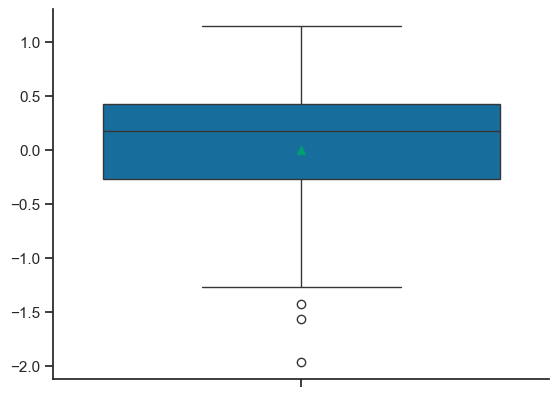

In [9]:
sns.boxplot(ols_residuals, showmeans=True)

<Axes: >

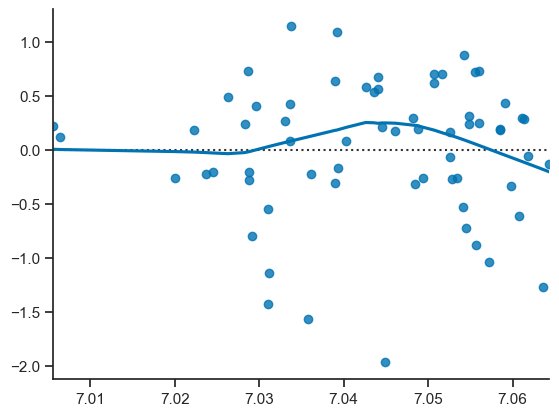

In [8]:
sns.residplot(x=ols_fitted, y=ols_residuals, lowess=True)

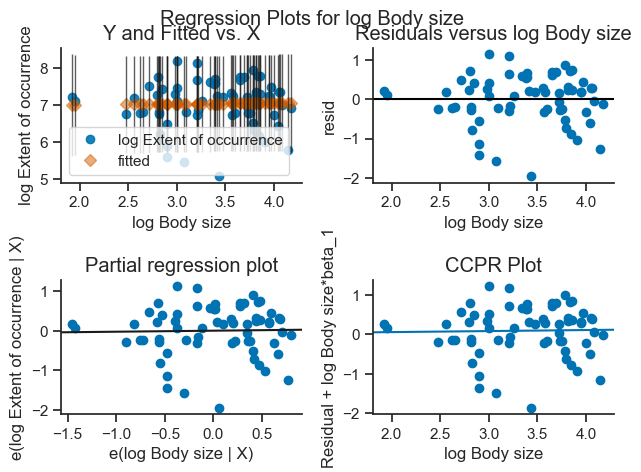

In [12]:
sm.graphics.plot_regress_exog(results=ols_model, exog_idx="log Body size")
fig.tight_layout(pad=1.0)

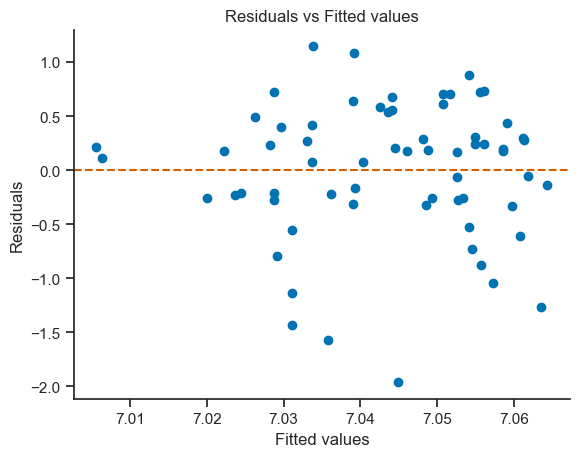

In [ ]:
plt.scatter(ols_fitted, ols_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted values")
plt.show()

Text(0, 0.5, 'log EOO (km$^2$)')

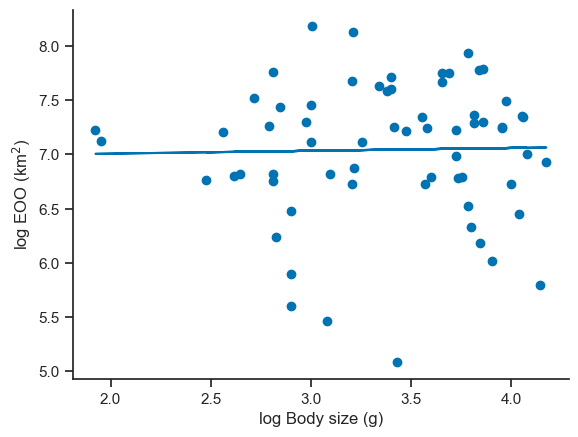

In [14]:
# Fit a polynomial with least squares polynomial fit
a, b = np.polyfit(
    x=scavengers["log Body size"], y=scavengers["log Extent of occurrence"], deg=1,
)

plt.scatter(
    y=scavengers["log Extent of occurrence"], x=scavengers["log Body size"],
) #  color="blue"
plt.plot(scavengers["log Body size"], a * scavengers["log Body size"] + b)

plt.xlabel("log Body size (g)")
plt.ylabel("log EOO (km$^2$)")

# plt.text(1, 90, "y = " + "{:.3f}".format(b) + " + {:.3f}".format(a) + "x", size=12)

## GLM comparison

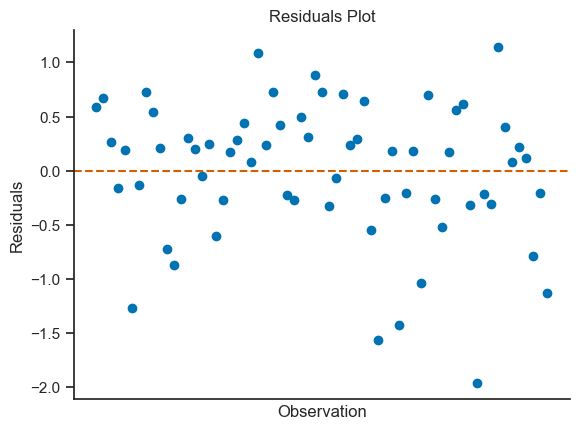

In [16]:
glm_model = sm.GLM(y, x, family=sm.families.Gaussian()).fit()
glm_residuals = glm_model.resid_response

plt.plot(glm_residuals, "o")
plt.axhline(y=0, color="r", linestyle="--")
plt.xticks([])
plt.xlabel("Observation")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()


# Obligate and facultative scavengers

Now we want to  include an interaction term in our regression, separating avian scavengers into obligate and facultative scavengers to see if examining these birds at this functional level will reveal a difference in the relationship between body size and range size . The interaction term will allow our groups to have their own intercepts.

We have two predictor variables, $x_1$ and $x_2$, for body size and diet. The first is quantitative continuous data, and the latter is categorical, "facultative" and "obligate", which we can have Python convert into numerical values by arbitrarily assigning one to be our baseline group, 0, and the other 1. Adding an interaction term will make the linear equation look like:

$$
    y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_{12}x_1x_2 + \epsilon
$$

Since one category in $x_2$ is a zero, this will allow us to calculate the best fit line 

<!-- where $\beta_{12}x_1x_2$ can be simplified to $\beta_3x_3$. -->

In [6]:
import patsy 

logEOO = np.log10(scavengers["Extent of occurrence"])
logBodySize = np.log10(scavengers["Body size"])

# Make the design matrices with Patsy
y, X = patsy.dmatrices('logEOO ~ logBodySize * Diet', data=scavengers, return_type='dataframe')

dummy_interaction_OLS = sm.OLS(y, X).fit()
print(dummy_interaction_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                 logEOO   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7522
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.525
Time:                        14:35:53   Log-Likelihood:                -61.086
No. Observations:                  65   AIC:                             130.2
Df Residuals:                      61   BIC:                             138.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [2]:
logEOO = np.log10(scavengers["Extent of occurrence"])
logBodySize = np.log10(scavengers["Body size"])

# Make the design matrices with Patsy
y, X = patsy.dmatrices('logEOO ~ logBodySize * Diet', data=scavengers, return_type='dataframe')

dummy_interaction_OLS = sm.OLS(y, X).fit()
print(dummy_interaction_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                 logEOO   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7522
Date:                Wed, 16 Apr 2025   Prob (F-statistic):              0.525
Time:                        13:34:58   Log-Likelihood:                -61.086
No. Observations:                  65   AIC:                             130.2
Df Residuals:                      61   BIC:                             138.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [9]:
# Extract coefficients from the model
intercept = dummy_interaction_OLS.params["Intercept"]
diet_obligate_coef = dummy_interaction_OLS.params["Diet[T.Obligate]"]
log_body_coef = dummy_interaction_OLS.params["logBodySize"]
interaction_coef = dummy_interaction_OLS.params["logBodySize:Diet[T.Obligate]"]

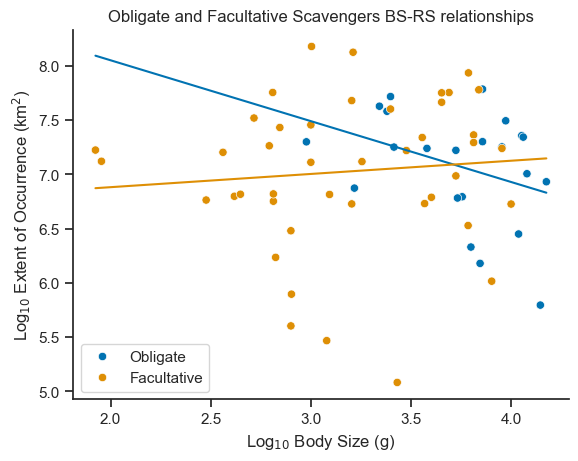

In [11]:
log_body_values = np.linspace(
    scavengers["log Body size"].min(),
    scavengers["log Body size"].max(),
    100,
)

# Calculate regression lines for obligate and facultative scavengers
log_eoo_obligate = (
    intercept
    + log_body_coef * log_body_values
    + diet_obligate_coef
    + interaction_coef * log_body_values
)
log_eoo_facultative = intercept + log_body_coef * log_body_values

# Create a scatter plot with regression lines for obligate and facultative scavengers
sns.scatterplot(
    data=scavengers,
    x="log Body size",
    y="log Extent of occurrence",
    hue="Diet",
)

# Plot regression lines
plt.plot(log_body_values, log_eoo_obligate)
plt.plot(log_body_values, log_eoo_facultative)

plt.xlabel("Log$_{10}$ Body Size (g)")
plt.ylabel("Log$_{10}$ Extent of Occurrence (km$^2$)")
plt.legend()
plt.title("Obligate and Facultative Scavengers BS-RS relationships")

plt.show()

In [7]:
# Assign new columns with syntactically compatible names. 
scavengers['logExtentOfOccurrence'] = scavengers['log Extent of occurrence']
scavengers['logBodySize'] = scavengers['log Body size']

interaction_ols = smf.ols(
    formula="logExtentOfOccurrence ~ logBodySize * Diet",
    data=scavengers,
).fit()
print(interaction_ols.summary())

                              OLS Regression Results                             
Dep. Variable:     logExtentOfOccurrence   R-squared:                       0.036
Model:                               OLS   Adj. R-squared:                 -0.012
Method:                    Least Squares   F-statistic:                    0.7522
Date:                   Wed, 16 Apr 2025   Prob (F-statistic):              0.525
Time:                           14:36:01   Log-Likelihood:                -61.086
No. Observations:                     65   AIC:                             130.2
Df Residuals:                         61   BIC:                             138.9
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------